# Subsampling approaches to MCMC for tall data

Last modified on 11th May 2015

This notebook illustrates various approaches to subsampling MCMC, see (Bardenet, Doucet, and Holmes, ICML'14 and a 2015 arxiv preprint entitled "On MCMC for tall data" by the same authors. By default, executing cells from top to bottom will reproduce the running examples in the latter paper. If you want to jump to a particular method, you should at least evaluate the first two sections beforehand ("Generate..." and "Vanilla MH"), as they contain functions and data that is used throughout the notebook. Please report any issue (or interesting discovery!) to the paper's corresponding author.

**Table of contents**    
[Generate toy data](#Generate-toy-data)  
[Vanilla MH](#Vanilla-isotropic-Gaussian-random-walk-Metropolis)  
[Informed subsampling](#ISS-MCMC)
[Confidence sampler without proxy](#Vanilla-confidence-sampler)  
[Confidence sampler with proxy](#Confidence-MH-with-2nd-order-Taylor-likelihood-proxy)  


In [19]:
%pylab inline
figsize(10,10) # in the global namespace when inline backend is in use.

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy as np
import numpy.random as npr
import numpy.linalg as npl
import scipy.stats as sps
import seaborn as sns
import seaborn.distributions as snsd

from algorithms.confidence_ss import confidenceMCMC 
from algorithms.confidence_ss import confidenceMCMCWithProxy
from algorithms.confidence_ss import confidenceMCMCWithProxyDroppedAlong
from algorithms.iss import iss_mcmc
from algorithms.vanillaMH import vanillaMH

sns.set(style="ticks");

plt.ioff() # turn off interactive plotting
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
plt.rc('axes', labelsize=22)
plt.rc('legend', fontsize=22)
mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True
saveDirStr = "figs"

## Generate toy data

First, let us generate some data. Change variable "dataType" to switch between the Gaussian and the lognormal examples from the paper. 

In [3]:
# Generate data
npr.seed(1)
N = 100000
# Here is where we make the model mis-specified
dataType = "Gaussian"
if dataType == "Gaussian":
    x = npr.randn(N)
elif dataType == "logNormal":
    x = npr.lognormal(0,1,size=N)
elif dataType == "laplace":
    x = npr.laplace(0,math.pow(0.5,0.5),size=N)

# We store the mean and std deviation for later reference, they are also the MAP and MLE estimates in this case.
realMean = np.mean(x)
realStd = np.std(x)
print("Mean of x =", realMean)
print("Std of x =", realStd)

# Where we will start all theta chains
initial_theta = np.array([realMean,np.log(realStd)])

Mean of x = 0.005253028489682668
Std of x = 0.9983292735417362


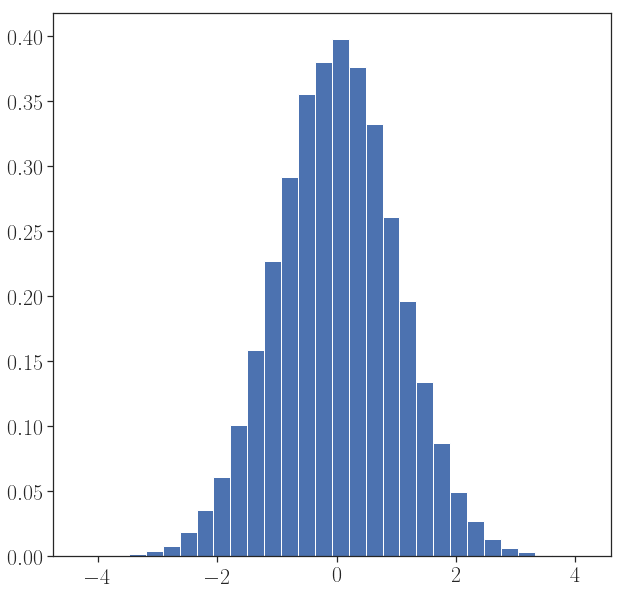

In [4]:
plt.clf()
plt.hist(x, 30, normed=True)
plt.show()

We are going to estimate the mean and std deviation of a Gaussian model, applied to the toy dataset generated above.

In [5]:
def getLogLhd(x, mu, sigma):
    """
    return an array of Gaussian log likelihoods up to a constant
    """
    return -(x-mu)**2/(2*sigma**2) - np.log(sigma)

In [6]:
def error(ref_chain,evaluated_chain):
    '''
    Given two one dimensional chains - this function evaluates the area difference in the histograms
    '''
    ref_values, ref_bins, _ = plt.hist(ref_chain, normed=True)
    alg_values, _, _ = plt.hist(evaluated_chain, bins=ref_bins, normed=True)
    alg_error = np.sum(numpy.diff(ref_bins)*abs(ref_values - alg_values)) 
    return alg_error

In [7]:
def latest_errors():
    mean_error = error(S_ref[:,0],S[:,0])
    std_error = error(S_ref[:,1],S[:,1])
    return (mean_error, std_error)

The following function plots the results as in the paper. It is a bit messy, but you can safely skip this cell without missing anything on the algorithms.

In [8]:
def plotResults(S, ns, algoName="doesNotMatter", weights="doesNotMatter", boolSave=0, figId="basic"):
    """
    plot results
    """    
    # Plot joint sample with seaborn
    m = np.min(S[:,0]) # Precompute limits for x and y plots
    M = np.max(S[:,0])
    m_ref = np.min(S_ref[:,0]) # Precompute limits for x and y plots
    M_ref = np.max(S_ref[:,0])
    
    xlimInf = min(m, m_ref)# - (M-m)/10
    xlimSup = max(M, M_ref)# +(M-m)/10
    print("xlims =", xlimInf, xlimSup) # +(M-m)/10
    xPlot = np.linspace(xlimInf, xlimSup, 1000)
    m = np.min(np.exp(S[:,1]))
    M = np.max(np.exp(S[:,1]))
    m_ref = np.min(np.exp(S_ref[:,1])) # Precompute limits for x and y plots
    M_ref = np.max(np.exp(S_ref[:,1]))
    ylimInf = min(m, m_ref)# - (M-m)/10
    ylimSup = max(M, M_ref)
    yPlot = np.linspace(ylimInf, ylimSup, 1000)
    
    g = sns.jointplot(S[:,0], np.exp(S[:,1]), kind="hex", space=0,size=10, xlim=(xlimInf,xlimSup), ylim=(ylimInf,ylimSup), stat_func=None, marginal_kws={"norm_hist":True}) # 
    plt.sca(g.ax_joint)
    plt.xlabel("$\mu$",)
    plt.ylabel("$\sigma$")
    
    # Add Reference long MH draw 
    # ... to the joint plot
    sns.kdeplot(S_ref[:,0], np.exp(S_ref[:,1]), ax=g.ax_joint, bw="silverman", cmap="BuGn_r", linewidth=5)
    # ... to the marginal plots
    g.ax_marg_x.plot(xPlot, marg0(xPlot), 'g', linewidth=6, label="Ref")
    g.ax_marg_y.plot(marg1(yPlot), yPlot, 'g', linewidth=6)
    
    # Add Bernstein von Mises approximations
    # ... to the joint plot
    X, Y = np.meshgrid(xPlot, yPlot)
    minusFisher = np.array([[1./realStd**2, 0],[0, 2./realStd**2]])
    SS = 1./N*npl.inv(minusFisher)
    Z = plt.mlab.bivariate_normal(X, Y, sigmax=np.sqrt(SS[0,0]), mux=realMean, muy=realStd, sigmay=np.sqrt(SS[1,1]), sigmaxy=np.sqrt(SS[0,1])) # Plot BvM approximation
    g.ax_joint.contour(X, Y, -Z, 1, colors="r", label="BvM", linestyle='--',linewidths=(6))
    # ... to the marginal plots
    g.ax_marg_x.plot(xPlot, sps.norm(realMean, np.sqrt(SS[0,0])).pdf(xPlot), color="red", linewidth=6, linestyle='--', label="BvM")
    g.ax_marg_y.plot(sps.norm(realStd, np.sqrt(SS[1,1])).pdf(yPlot), yPlot, color="red", linewidth=6, linestyle='--')
    
    # Print legend and save
    
    g.ax_marg_x.legend()
    print(saveDirStr+"chain_"+dataType+"_"+algoName+"_"+figId+".pdf")
    plt.savefig(saveDirStr+"chain_"+dataType+"_"+algoName+"_"+figId+".pdf")
      
    if boolSave:
        plt.savefig(saveDirStr+"chain_"+dataType+"_"+algoName+"_"+figId+".pdf")
        plt.savefig(saveDirStr+"chain_"+dataType+"_"+algoName+"_"+figId+".eps")
    plt.show()    
        
    # Plot autocorr of second component
    c = plt.acorr(np.exp(S[:,1]), maxlags=50, detrend=detrend_mean, normed=True)
    plt.clf()
    c = c[1][c[0]>=0]
    plt.plot(c, linewidth=3)
    plt.plot(c_ref, label="Ref", linewidth=3, color="g")
    plt.grid(True)
    
    plt.legend(loc=1)
    if boolSave:
            plt.savefig(saveDirStr+"autocorr_"+dataType+"_"+algoName+"_"+figId+".pdf")
            plt.savefig(saveDirStr+"autocorr_"+dataType+"_"+algoName+"_"+figId+".eps")
 
    plt.show()
      
    # Plot average number of likelihoods computed
    if not algoName =="vanillaMH":
        plt.hist(ns, histtype="stepfilled", alpha=.3)
        labStr = "mean="+str(np.around(1.0*np.mean(ns)/N*100,1))+"\%"
        plt.axvline(np.mean(ns), linewidth = 4, color="blue", label=labStr)
        labStr = "median="+str(np.around(1.0*np.median(ns)/N*100,1))+"\%"
        print("Median=", np.median(ns))
        plt.axvline(np.median(ns), linewidth = 4, color="blue",linestyle='--', label=labStr)
        plt.axvline(N, linewidth = 4, color="k", label="n") 
        plt.xlim([0, 2*N+1])
        plt.legend()
        if boolSave:
            plt.savefig(saveDirStr+"numLhdEvals_"+dataType+"_"+algoName+"_"+figId+".pdf")
            plt.savefig(saveDirStr+"numLhdEvals_"+dataType+"_"+algoName+"_"+figId+".eps")
            print("Plots saved")
        plt.show()

In [23]:
def plot_trace(chain, title1='Mean', title2='log(Std)'):
    '''
    Plots the trace of a given markov chain of Nx2 observations
    where 1st index of second dim is mean and 2nd index of second
    dim is std_dev.
    '''
    fig, (mean_ax, var_ax) = plt.subplots(2)
    steps = range(len(chain[:,0]))
    fig.suptitle('Trace of walk')
    mean_ax.set_title(title1)
    mean_ax.plot(steps,chain[:,0])
    var_ax.set_title(title2)
    var_ax.plot(steps,chain[:,1])
    plt.show()

## Vanilla isotropic Gaussian random walk Metropolis

In [10]:
# Longer reference run
S_ref = vanillaMH(initial_theta, x, time_budget=1200, chain_length=50000)

Iteration 0 Acceptance 0.0
Iteration 5000 Acceptance 0.4989002199560088
Iteration 10000 Acceptance 0.5052494750524947
Iteration 15000 Acceptance 0.5094993667088861
Iteration 20000 Acceptance 0.5139743012849357
Iteration 25000 Acceptance 0.514499420023199
Iteration 30000 Acceptance 0.514016199460018
Iteration 35000 Acceptance 0.5143281620525127
Iteration 40000 Acceptance 0.5144121396965076
Iteration 45000 Acceptance 0.5158774249461123


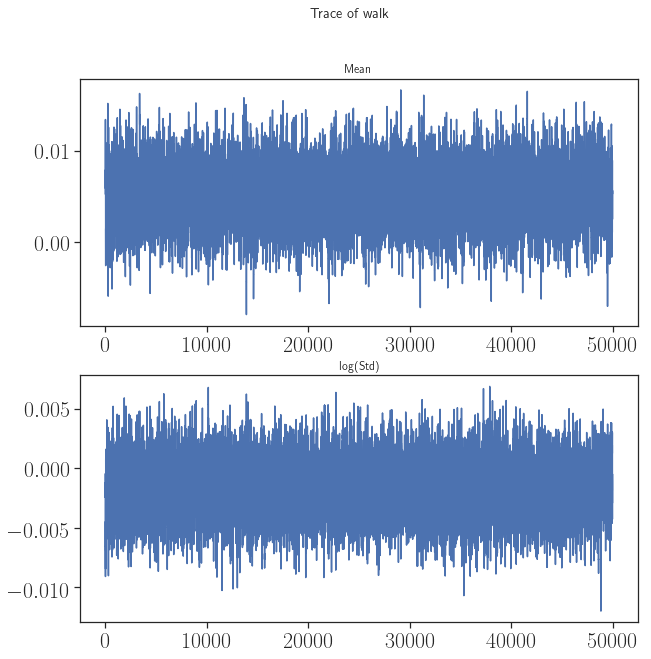

In [11]:
plot_trace(S_ref)

In [15]:
# Look for auto-correlation in mean and var chains
marg0 = sps.gaussian_kde(S_ref[:,0])
marg1 = sps.gaussian_kde(np.exp(S_ref[:,1]))
c = plt.acorr(np.exp(S_ref[:,1]), maxlags=50, detrend=detrend_mean, normed=True);
c_ref = c[1][c[0]>=0]
plt.show()

In [16]:
S = vanillaMH(initial_theta,x)

Iteration 0 Acceptance 1.0
Iteration 1000 Acceptance 0.4975024975024975
Iteration 2000 Acceptance 0.5197401299350325
Iteration 3000 Acceptance 0.5261579473508831
Iteration 4000 Acceptance 0.5306173456635841
Iteration 5000 Acceptance 0.5348930213957208
Iteration 6000 Acceptance 0.536910514914181
Iteration 7000 Acceptance 0.5366376231966862
Iteration 8000 Acceptance 0.5370578677665292
Iteration 9000 Acceptance 0.5374958337962449


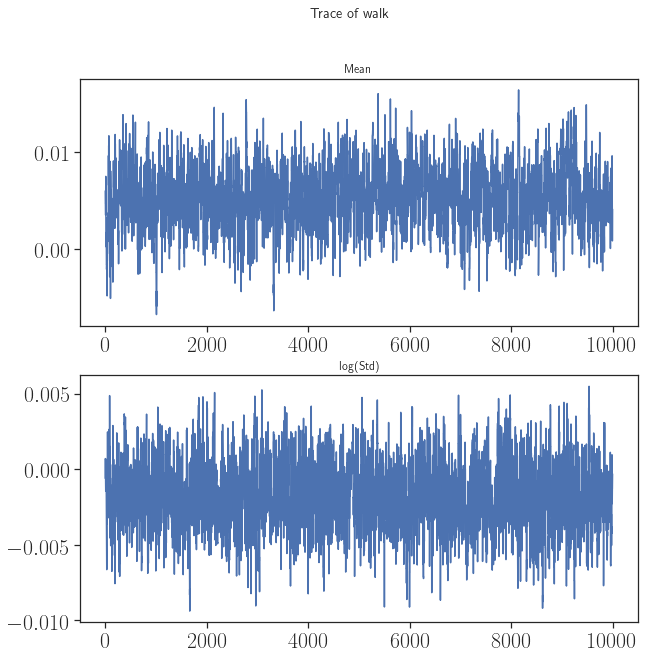

In [17]:
plot_trace(S)

xlims = -0.007941721062098044 0.016665090561080263
figschain_Gaussian_vanillaMH_basic.pdf


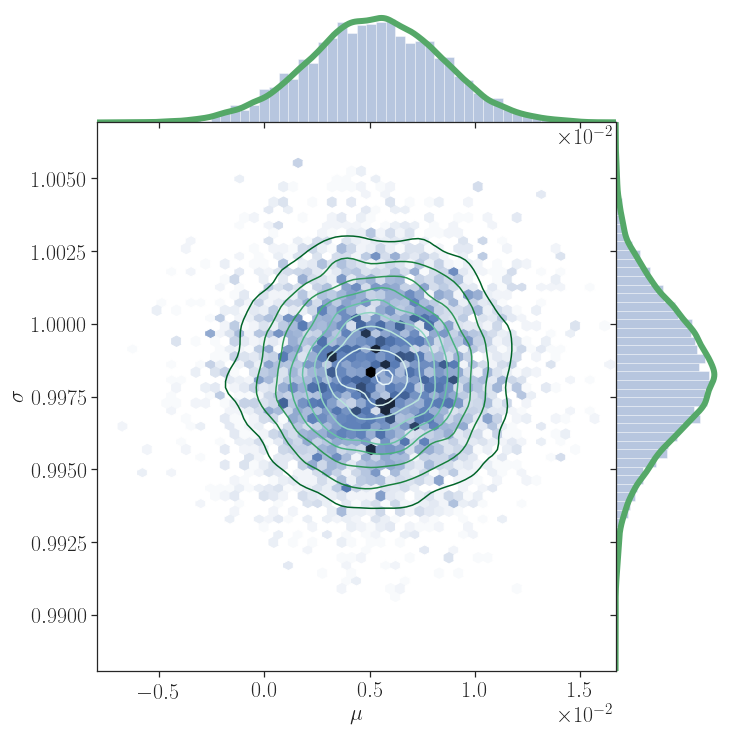

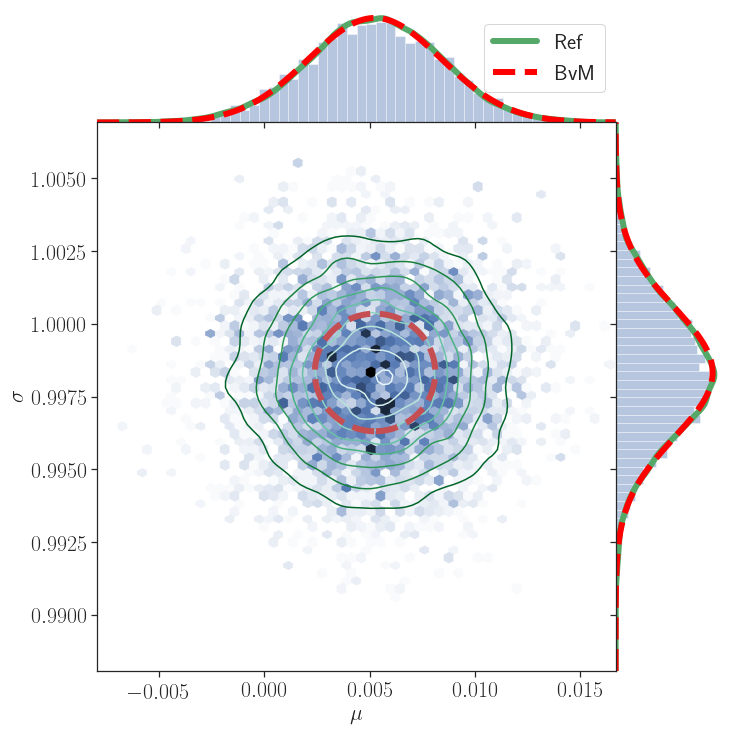

In [20]:
plotResults(S, [], algoName="vanillaMH", boolSave=1)

## ISS-MCMC

In [21]:
iss_chain, stats = iss_mcmc(initial_theta,x) 

Iteration 0 Theta Acceptance 1.0 Sample Acceptance 0.0
Iteration 1000 Theta Acceptance 0.7242757242757243 Sample Acceptance 0.013986013986013986
Iteration 2000 Theta Acceptance 0.7371314342828585 Sample Acceptance 0.0074962518740629685
Iteration 3000 Theta Acceptance 0.7280906364545152 Sample Acceptance 0.005331556147950683
Iteration 4000 Theta Acceptance 0.7225693576605848 Sample Acceptance 0.003999000249937516
Iteration 5000 Theta Acceptance 0.7220555888822235 Sample Acceptance 0.0033993201359728054
Iteration 6000 Theta Acceptance 0.7282119646725546 Sample Acceptance 0.002999500083319447
Iteration 7000 Theta Acceptance 0.7251821168404514 Sample Acceptance 0.002571061276960434
Iteration 8000 Theta Acceptance 0.7242844644419447 Sample Acceptance 0.0022497187851518562
Iteration 9000 Theta Acceptance 0.7202533051883124 Sample Acceptance 0.0019997778024663927


In [25]:
plot_trace(stats,'Sum','Sum of Squares')

xlims = -0.007941721062098044 0.016665090561080263
figschain_Gaussian_iss_mcmc_basic.pdf


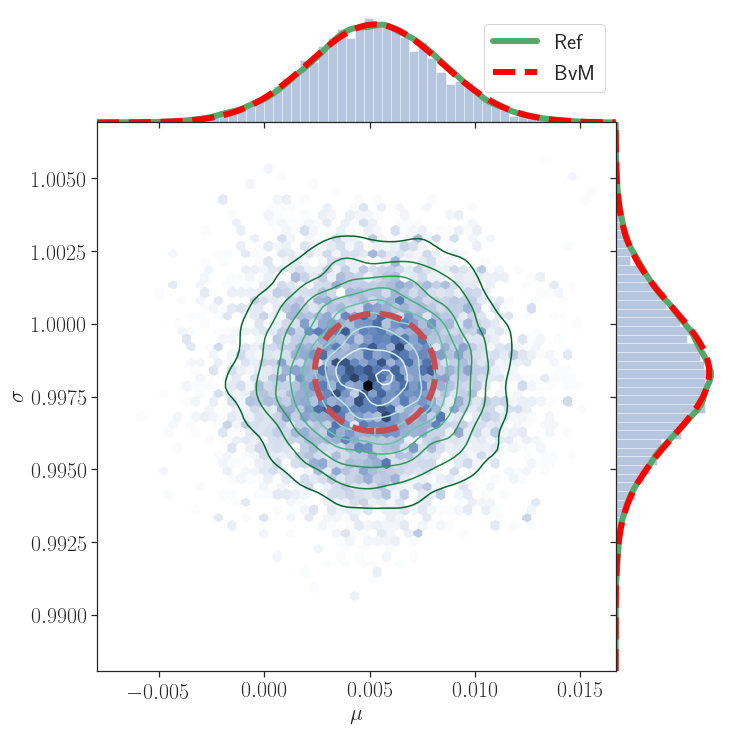

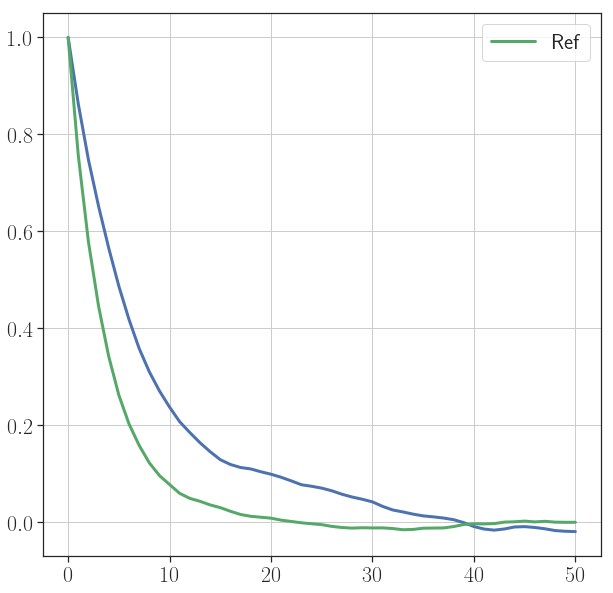

Median= nan
Plots saved


In [27]:
plotResults(iss_chain, [], algoName="iss_mcmc", boolSave=1)

## Vanilla confidence sampler

In [29]:
cs_chain, ns_B = confidenceMCMC(initial_theta, x)

Iteration 0 Acceptance 0.0 Avg. num evals 200000.0 sigma/sqrt(n) 3.373602566029676e-05 R/n 9.014324257952034e-07
Iteration 1000 Acceptance 0.49750249750249737 Avg. num evals 149071.54645354644 sigma/sqrt(n) 5.183100478316038e-06 R/n 1.9888671810875004e-07
Iteration 2000 Acceptance 0.49825087456271816 Avg. num evals 148767.9555222389 sigma/sqrt(n) 9.37820296517469e-06 R/n 3.7856851166590525e-07
Iteration 3000 Acceptance 0.4998333888703755 Avg. num evals 148782.0669776741 sigma/sqrt(n) 1.4064699042265954e-06 R/n 4.75670286829712e-08
Iteration 4000 Acceptance 0.4938765308672824 Avg. num evals 148677.7468132967 sigma/sqrt(n) 1.117351947446725e-05 R/n 3.790837045388118e-07
Iteration 5000 Acceptance 0.4975004999000197 Avg. num evals 148515.72905418917 sigma/sqrt(n) 1.9572122611241013e-05 R/n 7.188426003160891e-07
Iteration 6000 Acceptance 0.49691718046992145 Avg. num evals 148436.92167972005 sigma/sqrt(n) 1.7738790706729179e-06 R/n 6.608161265790507e-08
Iteration 7000 Acceptance 0.4970718468

xlims = -0.007941721062098044 0.018328868409476496
figschain_Gaussian_vanillaConfidence_basic.pdf


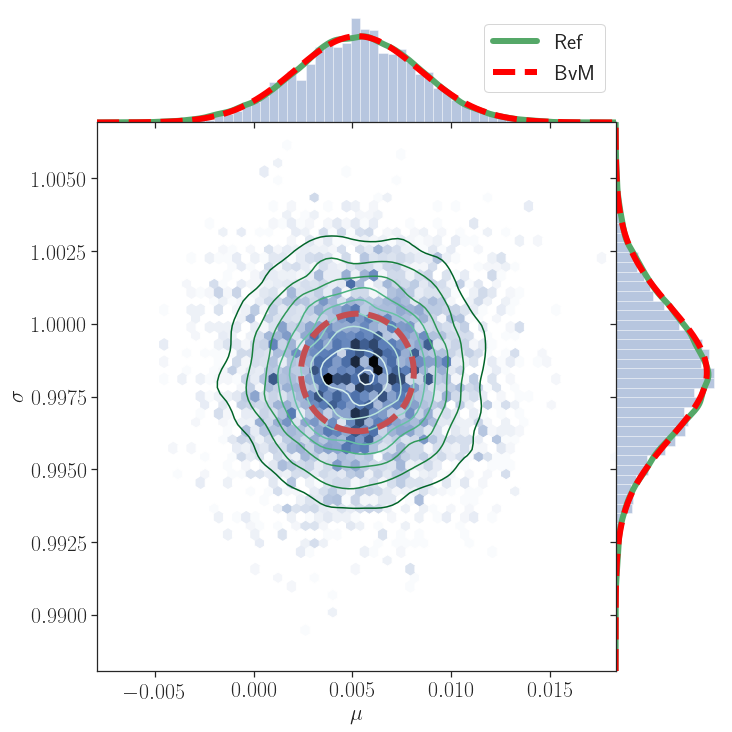

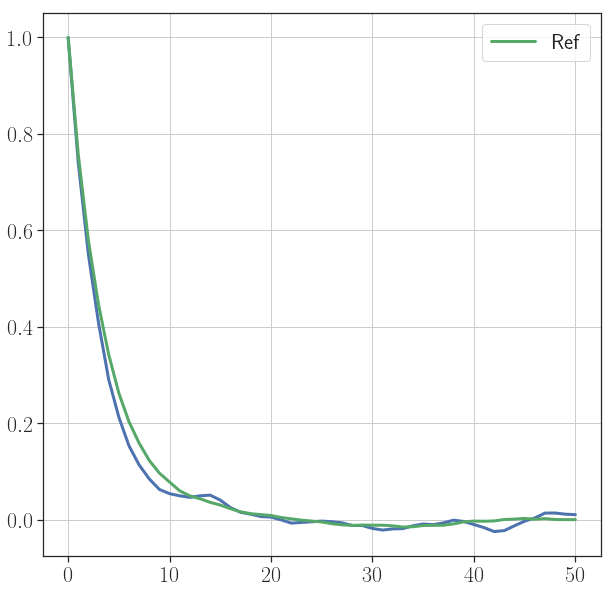

Median= 101250.0
Plots saved


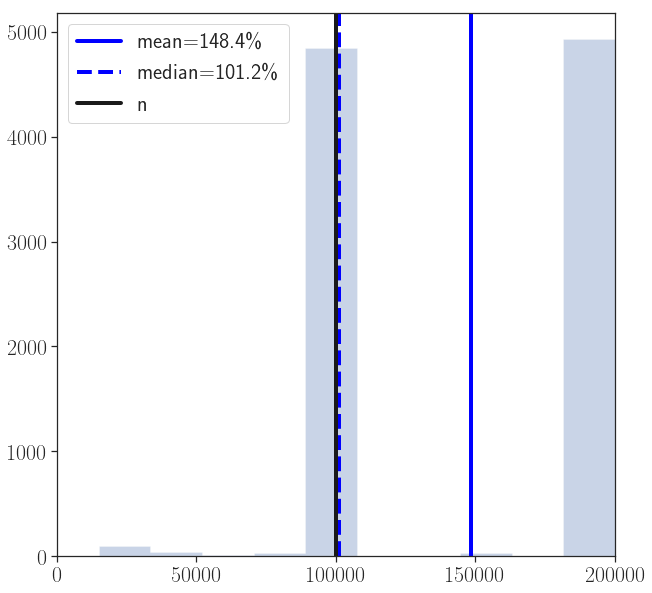

In [30]:
plotResults(S_B, ns_B, boolSave=1, algoName="vanillaConfidence")

## Confidence MH with 2nd order Taylor likelihood proxy

To apply the two Taylor expansions, it is enough to bound them on the union of the two segments 
$$\{(1-t)\theta^\star+t\theta, t\in[0,1]\}\cup\{(1-t)\theta^\star+t\theta', t\in[0,1]\},$$
where $\theta=(\mu,\sigma)$. Given their form, it is enough to bound them by taking the max of their absolute values when $\vert x-\mu\vert$ is maximal and $\sigma$ minimal in this union. Since the code is a bit hard to read, we have added a simple check of the bound in the algorithm to convince the reader the bound is correct.

In [ ]:
ics_chain, ns_BP = confidenceMCMCWithProxy(initial_theta,x)

In [ ]:
plotResults(ics_chain, ns_BP, algoName="confidenceProxy", boolSave=1)

## Confidence MCMC with proxys dropped along the way

This is a version of the confidence sampler with proxy that drops a proxy every 20 iterations.

In [ ]:
ics_chain_with_drop, ns_BPD = confidenceMCMCWithProxyDroppedAlong(initial_theta,x)

In [ ]:
plotResults(ics_chain_with_drop, ns_BPD, algoName="confidenceProxyWithDrop", boolSave=1)